In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D ,SeparableConv2D, MaxPooling2D , Input , GlobalAveragePooling2D ,AveragePooling2D, Dense , Dropout ,Activation, Flatten , BatchNormalization, add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, save_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from numpy import loadtxt
from sklearn import metrics
from sklearn.metrics import f1_score, recall_score, confusion_matrix, roc_auc_score, average_precision_score
from sklearn.metrics import roc_curve, precision_recall_curve, auc
from sklearn.model_selection import train_test_split
import json
debug = True

combined_dataset = pd.read_csv("/kaggle/input/combined-dataset-before-smote/output-2.csv", header=None, delimiter=',')
print(combined_dataset)
all_scores = {}
batch_size = 16
epochs = 30

2024-10-23 05:30:45.710204: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-23 05:30:45.710317: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-23 05:30:45.849917: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


        0    1    2   3   4    5    6   7   8   9   ...  20  21   22  23  24  \
0       83   77    7  21  11   11   41  19   9  83  ...   7  34   24  12  38   
1       11    3  106  42   5    8  110   9  92   1  ...  10   9  125  52  11   
2       18   50   20  15  18   12   17  46  40  26  ...  12   2   26  47   3   
3        4   21  100   9  61    7   18  74  50  23  ...  75  18   67  22   8   
4       10  103   97  62  40   49   20  90  22  11  ...  28  40   86  78  19   
...     ..  ...  ...  ..  ..  ...  ...  ..  ..  ..  ...  ..  ..  ...  ..  ..   
147108  96   77   36  69   6    6   77  70  45  88  ...   9  34   24  31  22   
147109  10    2    5  51  10   62   20  55  83  12  ...  10  19   85  80  53   
147110  31   51    5   1  74  105   51  65  20  49  ...  25  59   86  17  60   
147111   9    1   28   2  20   12   14  74  50  23  ...  74  39   36  22  18   
147112  16   17    2   2  60    7   14  74  50  16  ...  74   5   44  14   5   

        25  26  27  28  29  
0       37

In [2]:
x_ = combined_dataset.drop(columns=[26, 27, 28, 29])
y_ = combined_dataset.filter([26, 27, 28, 29])
x_train, x_test, y_train, y_test = train_test_split(x_, y_, test_size=0.2, random_state=42)

# Reshape input data
x_train = x_train.values.reshape(-1, x_train.shape[1], 1, 1)
x_test = x_test.values.reshape(-1, x_test.shape[1], 1, 1)

if debug:
    print('shape of x_train after reshaping', x_train.shape)
    print('shape of x_test after reshaping', x_test.shape)

#determine batch size
batch_size = min(x_train.shape[0] / 10, batch_size)
if debug:
    print('batch size: ' + str(batch_size))

# Modify input shape accordingly
input_shape = (x_train.shape[1], 1, 1)
# Create the input layer
inputs = Input(shape=input_shape)

# Entry Flow
x = Conv2D(32, (3, 3), strides=(2, 2), padding='same')(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

previous_block_activation = x
for size in [128, 256, 728]:
    x = Activation('relu')(x)
    x = Conv2D(size, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)

    x = Activation('relu')(x)
    x = Conv2D(size, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    residual = Conv2D(size, (1, 1), strides=(2, 2), padding='same')(previous_block_activation)
    x = add([x, residual])
    previous_block_activation = x

def middle_flow(x, num_blocks=8):
    previous_block_activation = x

    for _ in range(num_blocks):
        x = Activation('relu')(x)
        x = SeparableConv2D(728, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = Activation('relu')(x)
        x = SeparableConv2D(728, 3, padding='same')(x)
        x = BatchNormalization()(x)

        x = add([x, previous_block_activation])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    return x

def exit_flow(x, num_classes):
    previous_block_activation = x

    x = Activation('relu')(x)
    x = SeparableConv2D(728, 3, padding='same')(x)
    x = BatchNormalization()(x)

    x = Activation('relu')(x)
    x = SeparableConv2D(1024, 3, padding='same')(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D(3, strides=2, padding='same')(x)

    residual = Conv2D(  # Project residual
        1024, 1, strides=2, padding='same')(previous_block_activation)
    x = add([x, residual])  # Add back residual

    x = SeparableConv2D(1536, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = SeparableConv2D(2048, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = GlobalAveragePooling2D()(x)

    if num_classes == 1:
        activation = 'sigmoid'
    else:
        activation = 'softmax'

    return Dense(num_classes, activation=activation)(x)



# Define the number of classes based on your task
num_classes = 4  # Adjust this according to your task

# Final Dense Layer
x = GlobalAveragePooling2D()(x)
if num_classes == 1:
    activation = 'sigmoid'
else:
    activation = 'softmax'
outputs = Dense(num_classes, activation=activation)(x)

# Create the model
model = Model(inputs, outputs)

# Compile the model with an appropriate optimizer, loss function, and metrics
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size)

y_pred = model.predict(x_test)
y_pred = (y_pred > 0.5).astype(int)

shape of x_train after reshaping (117690, 26, 1, 1)
shape of x_test after reshaping (29423, 26, 1, 1)
batch size: 16
Train on 117690 samples
Epoch 1/30
117690/117690 [==============================] - 95s 811us/sample - loss: 0.6522 - acc: 0.5240
Epoch 2/30
117690/117690 [==============================] - 91s 776us/sample - loss: 0.5804 - acc: 0.5547
Epoch 3/30
117690/117690 [==============================] - 91s 776us/sample - loss: 0.5274 - acc: 0.5845
Epoch 4/30
117690/117690 [==============================] - 91s 776us/sample - loss: 0.4839 - acc: 0.6068
Epoch 5/30
117690/117690 [==============================] - 91s 777us/sample - loss: 0.4451 - acc: 0.6224
Epoch 6/30
117690/117690 [==============================] - 91s 776us/sample - loss: 0.4098 - acc: 0.6341
Epoch 7/30
117690/117690 [==============================] - 91s 775us/sample - loss: 0.3802 - acc: 0.6441
Epoch 8/30
117690/117690 [==============================] - 91s 775us/sample - loss: 0.3549 - acc: 0.6508
Epoch 9/30


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [3]:
y_test = np.array(y_test)
y_test = y_test.flatten()
y_pred = y_pred.flatten()

Confusion Matrix: [[55635  4513]
 [34333 23211]]


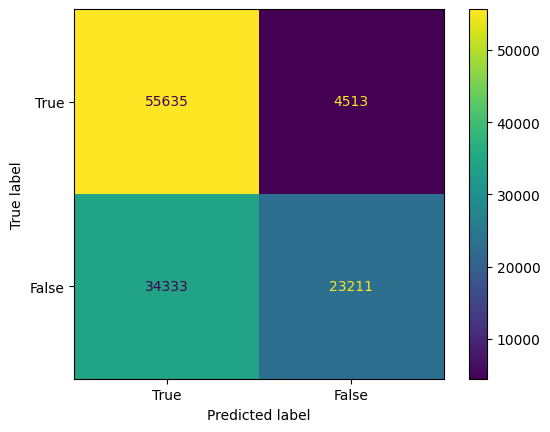

FPR: 0.07503158874775553 TPR: 0.40336090643681355


In [4]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:",cm)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [True, False])
cm_display.plot()
plt.savefig('/kaggle/working/xception_cm_no_smote.png')
plt.show()

fpr_cm = cm[0, 1] / (cm[0, 1] + cm[0, 0])
tpr_cm = cm[1, 1] / (cm[1, 1] + cm[1, 0])

print("FPR:", fpr_cm, "TPR:", tpr_cm)

ROC: 0.664164658844529


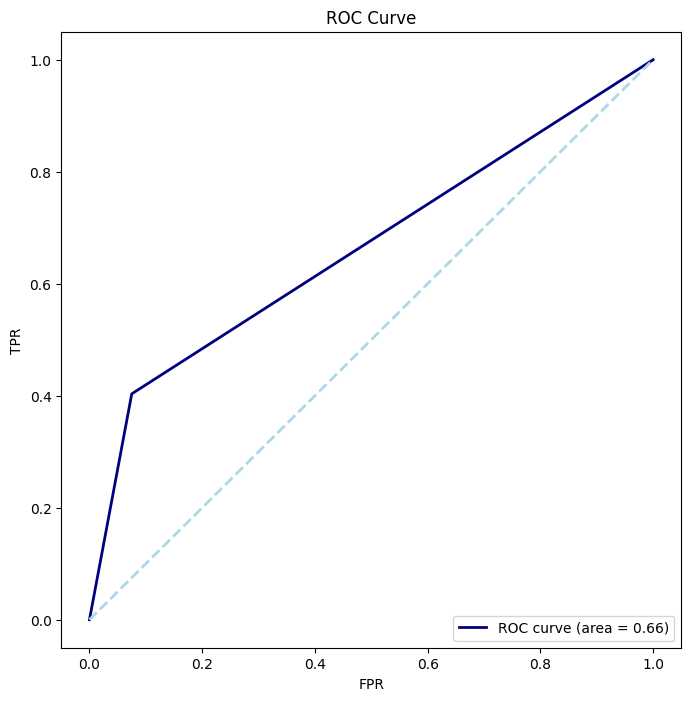

In [5]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print("ROC:",roc_auc)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='navy', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='lightblue', lw=2, linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.savefig('/kaggle/working/xception_roc_no_smote.png')
plt.show()

PRC: 0.7661484107898799


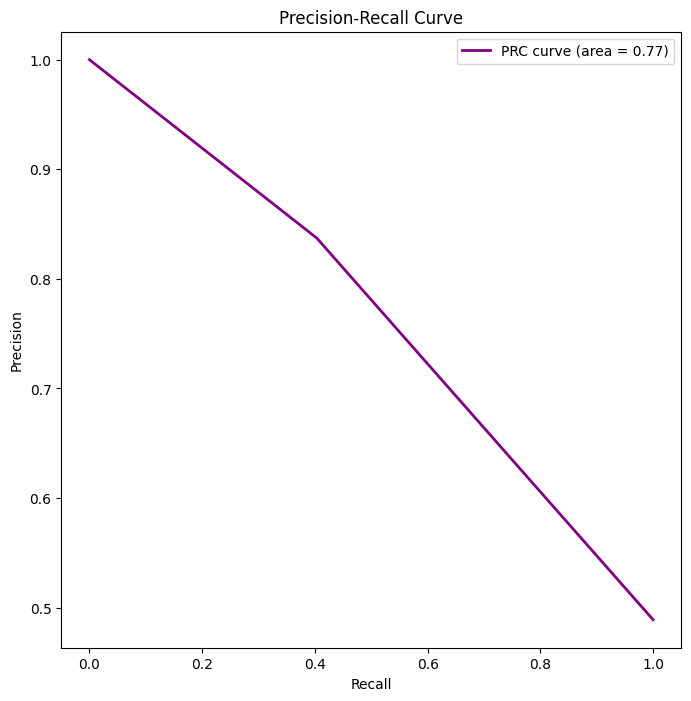

In [6]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
prc_auc = auc(recall, precision)
print("PRC:",prc_auc)

plt.figure(figsize=(8, 8))
plt.plot(recall, precision, color='purple', lw=2, label='PRC curve (area = {:.2f})'.format(prc_auc))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')
plt.savefig('/kaggle/working/xception_prc_no_smote.png')
plt.show()

In [7]:
f1_score_value = f1_score(y_test, y_pred, average='macro')
recall_score_value = recall_score(y_test, y_pred, average='macro')

print("F1 score:",f1_score_value,"recall score:", recall_score_value)

F1 score: 0.6428257111165332 recall score: 0.664164658844529


In [8]:
all_scores= {
    'F1 Score': f1_score_value,
    'Recall': recall_score_value,
    'FPR': fpr_cm,
    'TPR': tpr_cm,
    'ROC AUC': roc_auc,
    'PRC AUC': prc_auc
    }
print('F1 Score:', f1_score_value)
print('Recall:', recall_score_value)
print('FPR:', fpr_cm)
print('TPR:', tpr_cm)
print('ROC AUC:', roc_auc)
print('PRC AUC:', prc_auc)
print('All Scores:', all_scores)

F1 Score: 0.6428257111165332
Recall: 0.664164658844529
FPR: 0.07503158874775553
TPR: 0.40336090643681355
ROC AUC: 0.664164658844529
PRC AUC: 0.7661484107898799
All Scores: {'F1 Score': 0.6428257111165332, 'Recall': 0.664164658844529, 'FPR': 0.07503158874775553, 'TPR': 0.40336090643681355, 'ROC AUC': 0.664164658844529, 'PRC AUC': 0.7661484107898799}


In [9]:
dict_string = json.dumps(all_scores)
file_path = '/kaggle/working/output_no_smote.txt'

with open(file_path, 'w') as file:
    file.write(dict_string)

scores_table =({
    'Metric': ['F1 Score', 'True Positive Rate', 'False Positive Rate'],
    'Score': [f1_score_value, tpr_cm, fpr_cm]
})
dict_string2 = json.dumps(scores_table)
file_path2 = '/kaggle/working/scores_table_no_smote.txt'
with open(file_path2,'w') as file:
    file.write(dict_string2)

print(scores_table)

{'Metric': ['F1 Score', 'True Positive Rate', 'False Positive Rate'], 'Score': [0.6428257111165332, 0.40336090643681355, 0.07503158874775553]}


In [10]:
np.savetxt('/kaggle/working/y_test_no_smote.txt', y_test, fmt='%d')
np.savetxt('/kaggle/working/y_pred_no_smote.txt', y_pred, fmt='%d')
np.savetxt('/kaggle/working/tpr_no_smote.txt', tpr, fmt='%d')
np.savetxt('/kaggle/working/fpr_no_smote.txt', fpr, fmt='%d')

In [11]:
model.save('/kaggle/working/no_smote_xception.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [12]:


import json

# Assuming tpr and fpr are NumPy arrays
print("Type of f1:", type(f1_score_value))
print("Type of precision:", type(precision))
print("Type of recall:", type(recall))
print("Type of tpr_value:", type(tpr_cm))
print("Type of fpr_value:", type(fpr_cm))
print("Type of roc_auc:", type(roc_auc))
print("Type of prc_auc:", type(prc_auc))
print("Type of tpr:", type(tpr))
print("Type of fpr:", type(fpr))

precision_list = precision.tolist()
recall_list = recall.tolist()
tpr_list = tpr.tolist()
fpr_list = fpr.tolist()

#print(f1.type())

data = {
    "Average F1 Score": float(f1_score_value), 
    #"Average Precision": float(precision_score_value), 
    "Average Recall": float(recall_score_value), 
    "Average True Positive Rate": float(tpr_cm), 
    "Average False Positive Rate": float(fpr_cm), 
    "Average ROC AUC": roc_auc, 
    "Average PRC AUC": prc_auc,
    "TPR Array" : tpr_list,
    "FPR Array" : fpr_list,
    "Precision Array": precision_list, 
    "Recall Array": recall_list
}

# Specify the file path
file_path = "/kaggle/working/Xception - Synthetic SMOTE - Lenny.json"

# Write the data to a JSON file
with open(file_path, "w") as json_file:
    json.dump(data, json_file)

Type of f1: <class 'numpy.float64'>
Type of precision: <class 'numpy.ndarray'>
Type of recall: <class 'numpy.ndarray'>
Type of tpr_value: <class 'numpy.float64'>
Type of fpr_value: <class 'numpy.float64'>
Type of roc_auc: <class 'numpy.float64'>
Type of prc_auc: <class 'numpy.float64'>
Type of tpr: <class 'numpy.ndarray'>
Type of fpr: <class 'numpy.ndarray'>
